In [1]:
import sys
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
COMPETION_DATA_DIR = '/content/drive/MyDrive/input/kaggle/feedback-prize-english-language-learning'
iter_path = COMPETION_DATA_DIR + '/iterativestratification'

In [3]:
!pip install tokenizers
!pip install transformers
!pip install iterstrat
!pip install sentencepiece

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 7.6 MB 7.0 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.5 MB 6.9 MB/s 
     |████████████████████████████████| 182 kB 80.9 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: Could not find a version that satisfies the requirement iterstrat (from versions: none)
ERROR: No matching distribution found for iterstrat
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.3 MB 7.4 MB/s 


In [4]:
pip install --upgrade pip

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.1 MB 6.6 MB/s 
  Attempting uninstall: pip
    Found existing installation: pip 21.1.3
    Uninstalling pip-21.1.3:
      Successfully uninstalled pip-21.1.3


In [5]:
import numpy as np
import pandas as pd
import os
import os
import gc
import re
import ast
import copy
import json
import time
import math
import string
import pickle
import random
import joblib
import itertools
import warnings
warnings.filterwarnings("ignore")
import scipy as sp
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
from tqdm.auto import tqdm
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import StratifiedKFold, GroupKFold, KFold
sys.path.append(iter_path)
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
import torch
import torch.nn as nn
from torch.nn import Parameter
import torch.nn.functional as F
from torch.optim import Adam, SGD, AdamW
from torch.utils.data import DataLoader, Dataset
from torch.utils import checkpoint
import tokenizers
import transformers
from transformers import AutoTokenizer, AutoModel, AutoConfig
from transformers import get_linear_schedule_with_warmup, get_cosine_schedule_with_warmup
%env TOKENIZERS_PARALLELISM=true
%matplotlib inline
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
import sentencepiece

env: TOKENIZERS_PARALLELISM=true


In [6]:
class CFG:
    eda = False
    debug = False
    load_bert_data = False
    load_test_only = False
    model_train = False
    train_multi = True
    train_staking = False
    train_ensumbling = True
    headrow = 3
    num_workers=4
    gradient_checkpointing=True
    scheduler='cosine' # ['linear', 'cosine']
    batch_scheduler=True
    num_cycles=0.5
    num_warmup_steps=0
    epochs=4
    encoder_lr=2e-5
    decoder_lr=2e-5
    min_lr=1e-6
    eps=1e-6
    betas=(0.9, 0.999)
    batch_size=8
    max_len=512
    weight_decay=0.01
    gradient_accumulation_steps=1
    max_grad_norm=1000
    target_cols=['cohesion', 'syntax', 'vocabulary', 'phraseology', 'grammar', 'conventions']
    seed=42
    n_fold=25
    train=True
    
if CFG.debug:
    CFG.n_fold = 5
    
if CFG.train_staking == False & CFG.train_ensumbling == False:
    CFG.train_ensumbling = True

In [7]:
target_cols = ['cohesion', 'syntax', 'vocabulary', 'phraseology', 'grammar', 'conventions',]

In [8]:
def seed_everything(seed=CFG.seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True


seed_everything(seed=42)


def get_essay(essay_id, is_train=True):
    parent_path = INPUT_DIR + 'train' if is_train else INPUT_DIR + 'test'

    try:
        essay_path = os.path.join(parent_path, f"{essay_id}.txt")
        essay_text = open(essay_path, 'r').read()
        return essay_text
    except:
        return ''

def criterion_val(outputs, labels):
    return nn.CrossEntropyLoss()(outputs, labels)


def criterion_train(outputs, labels):
    return nn.CrossEntropyLoss()(outputs, labels)

In [9]:
from transformers import AutoModel,AutoTokenizer
import torch
import torch.nn.functional as F
from tqdm import tqdm

In [10]:
INPUT_DIR = '/content/drive/MyDrive/input/kaggle/feedback-prize-effectiveness/'

In [11]:
train = pd.read_csv(INPUT_DIR + 'train.csv')
if CFG.debug:
    train = train[:1000]
test = pd.read_csv(INPUT_DIR + 'test.csv')
print(train.head())
print(train.shape)
print(test.head())
print(test.shape)

   discourse_id      essay_id                                     discourse_text discourse_type discourse_effectiveness
0  0013cc385424  007ACE74B050  Hi, i'm Isaac, i'm going to be writing about h...           Lead                Adequate
1  9704a709b505  007ACE74B050  On my perspective, I think that the face is a ...       Position                Adequate
2  c22adee811b6  007ACE74B050  I think that the face is a natural landform be...          Claim                Adequate
3  a10d361e54e4  007ACE74B050  If life was on Mars, we would know by now. The...       Evidence                Adequate
4  db3e453ec4e2  007ACE74B050  People thought that the face was formed by ali...   Counterclaim                Adequate
(36765, 5)
   discourse_id      essay_id                                     discourse_text discourse_type
0  a261b6e14276  D72CB1C11673  Making choices in life can be very difficult. ...           Lead
1  5a88900e7dc1  D72CB1C11673  Seeking multiple opinions can help a person ma

In [12]:
pseudo_train = train['essay_id'].drop_duplicates().reset_index(drop = False)

In [13]:
pseudo_train['full_text'] = pseudo_train['essay_id'].apply(lambda x: get_essay(x, is_train=True))

In [14]:
pseudo_train.head()

,index,essay_id,full_text
0,0,007ACE74B050,"Hi, i'm Isaac, i'm going to be writing about h..."
1,9,00944C693682,Limiting the usage of cars has personal and pr...
2,20,00BD97EA4041,Should computers read the emotional expression...
3,27,00C6E82FE5BA,I think that it wouldn't be valueable to have ...
4,33,013B9AA6B9DB,"What is that thing on Mars?\n\nWell, some peop..."


In [15]:
!pip install readability

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for readability: filename=readability-0.3.1-py3-none-any.whl size=35478 sha256=779f3284fefc04b2a2ea743e328c5e8bd9c5ad14c185c5e1ca3e888663302d35
  Stored in directory: /root/.cache/pip/wheels/28/ba/3f/3b87f773e42dc62abfc33964fd7417875827c8d2c016f4c1d1
Successfully built readability


In [16]:
import readability
import pandas as pd
import re
import seaborn as sns

In [17]:
def data_cleaner(text):
    text = text.strip()
    text = re.sub(r'\n', '', text)
    text = text.lower()
    return text

In [18]:
def calc_readability(text):

    results = readability.getmeasures(text, lang='en')

    return results['readability grades']['ARI']

In [19]:
pseudo_train['full_text'] = pseudo_train['full_text'].apply(data_cleaner)
pseudo_train['readability'] = pseudo_train['full_text'].apply(calc_readability)
pseudo_train['words'] = pseudo_train['full_text'].apply(lambda x: len(x.split()))

In [20]:
pseudo_train.head()

,index,essay_id,full_text,readability,words
0,0,007ACE74B050,"hi, i'm isaac, i'm going to be writing about h...",176.028464,347
1,9,00944C693682,limiting the usage of cars has personal and pr...,440.813061,869
2,20,00BD97EA4041,should computers read the emotional expression...,141.228790,271
3,27,00C6E82FE5BA,i think that it wouldn't be valueable to have ...,148.242100,295
4,33,013B9AA6B9DB,"what is that thing on mars?well, some people b...",107.512192,216


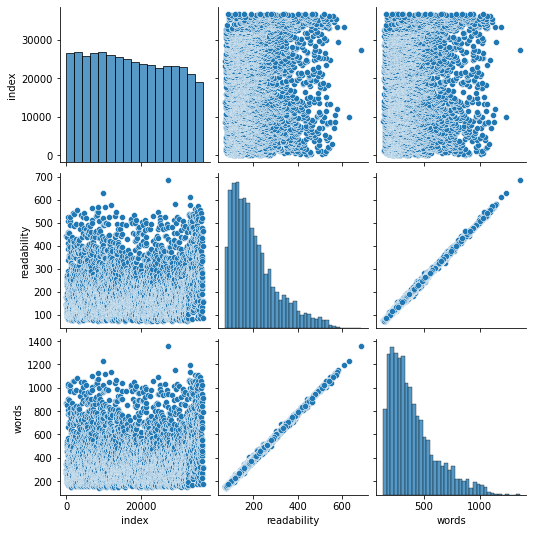

In [21]:
sns.pairplot(pseudo_train)

In [22]:
min_readability = 92.793281
max_readability = 396.656655
min_words = 185.000000
max_words = 783.000000

In [23]:
pseudo_train = pseudo_train[
    (pseudo_train['readability'] >= min_readability)
    &(pseudo_train['readability'] <= max_readability)
    &(pseudo_train['words'] >= min_words)
    &(pseudo_train['words'] <= max_words)
].reset_index(drop = True)

In [24]:
pseudo_train.shape

(3556, 5)

In [25]:
pseudo_train.shape

(3556, 5)

In [26]:
pseudo_train_std_df = pd.DataFrame()
pseudo_train_std_df['essay_id'] = sub['essay_id']
pseudo_train_std_df['full_text'] = sub['full_text']
for t in target_cols: 

    calc_mean = np.mean(final_pred[t], axis = 1)
    pseudo_train_std_df[t+'_mean'] = calc_mean

    calc_std = np.std(final_pred[t], axis = 1)
    pseudo_train_std_df[t+'_std'] = calc_std

NameError: ignored

In [ ]:
pseudo_train_std_df

In [ ]:
pseudo_train_std_df['std_sum'] = 0
for t in target_cols: 
    pseudo_train_std_df['std_sum'] += pseudo_train_std_df[t+'_std']
pseudo_train_std_df

In [ ]:
pseudo_train_std_df = pseudo_train_std_df.sort_values('std_sum')
pseudo_train_std_df

In [ ]:
pseudo_train_std_df['std_sum'].hist()

In [ ]:
len(pseudo_train_std_df[pseudo_train_std_df['std_sum'] <= 1])

In [ ]:
for t in target_cols: 
    pseudo_train_std_df[pseudo_train_std_df['std_sum'] <= 1][t].hist()
    plt.show()

In [ ]:
pseudo_output_df = pseudo_train_std_df[pseudo_train_std_df['std_sum'] <= 1]
pseudo_output_df.head()

In [ ]:
pseudo_output_df = pseudo_output_df[['essay_id', 'full_text', 'cohesion', 'syntax', 'vocabulary', 'phraseology', 'grammar', 'conventions']].rename(columns = {'essay_id':'text_id'})
pseudo_output_df.head()

In [ ]:
for t in target_cols: 
    pseudo_output_df[t] = np.round(pseudo_output_df[t]*2, 0) / 2
pseudo_output_df.head()

In [ ]:
pseudo_output_df.to_csv(COMPETION_DATA_DIR + '/pseudo_train2.csv', index = False)